# Modeling & Classification.


~~usar varios clusters, uno de 3grams, uno de nouns, uno de embeddings~~   
~~con esto buscar un clasificador multilabel (o simplemente agregarlos como features del modelo que le fedee al clasificador)~~  

Des métodos para clusterizar:  
-primero hago cluster separados para Tags, 2-3grams, Keys  
    luego agrego estas nuevas features al embedding, con eso puedo entrenar el clasificador.      
  
-segundo usando topic modeling q todavia no investigue  

  

Representaciones Vectoriales:

- CountVectorizer, TDIDF:
    * QTags, QKeys, AKeys, QKeys-AKeys, 2-3ngrams  
  
- FastText,spaCy,Word2Vec  
    * Qless, QLemmas, Q-ANS, Qless-ANSless  
  

- SBERT  
    * Q, QLess, A, Aless  


- Topic Modeling: LDA, LSA  

Orden:
Crear Espacio,
normalizarlo,
reducirlo,
hacerle kmeans,
obtener los clusters,
medir siluete, gap, inertia, y precision con mi database.
Agregar la medicion al df de mediciones.






In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv("db/features.csv", index_col=0)
df = df.set_index("id")

test_df = pd.read_csv("db/test_db.csv", index_col=0)
true_df = test_df[test_df["2"]]
false_df = test_df[test_df["2"] == False]

df


,Qscore,Q,Qless,Qlemmas,Qkeys,ANSscore,ANS,Aless,Alemmas,Akeys
id,,,,,,,,,,
bc60pk,14,"Donut or doughnut, & where are you from?","Donut doughnut, & ?","Donut doughnut , & ?",Donut_NNP doughnut_NN,6.0,"donut, southern usa","donut, southern usa","donut , southern usa",donut_NN usa_NN
289mmm,2,Help finding a song from a video description?,Help finding song video description?,Help finding song video description ?,Help_NNP finding_NN song_NN video_NN descripti...,2.0,/r/tipofmytongue,/r/tipofmytongue,/r/tipofmytongue,/r/tipofmytongue_NN
rufpr/,898,"I was rapedNo, we had sex","I rapedNo, sex","I rapedNo , sex",I_PRP rapedNo_VBP sex_NN,1286.0,"if its not a yes, its no.","yes, .","yes , .",yes_RB
24vtw3,22,Jesus H. Christ what's his middle name?,Jesus H. Christ 'middle name?,Jesus H. Christ 'middle name ?,Jesus_NNP H._NNP Christ_NNP name_NN,35.0,umm... Holy. As in Holy Christ. Isn't this com...,umm... Holy. As Holy Christ. Isn'common knowle...,umm ... Holy . As Holy Christ . Isn'common kno...,umm_NN Holy_NNP As_IN Holy_NNP Christ_NNP Isn'...
sv054/,0,Judith from hotmail sent me a message..... ),Judith hotmail sent message..... ),Judith hotmail sent message ..... ),Judith_NNP hotmail_NN sent_VBD message_NN .......,3.0,sounds like a great idea!,sounds like great idea!,sound like great idea !,sound_NN like_IN idea_NN
...,...,...,...,...,...,...,...,...,...,...
orgpc4,1,"Quiet people, what are your strengths?","Quiet people, strengths?","Quiet people , strength ?",people_NNS strength_NN,4.0,"Observing, attention, memory,","Observing, attention, memory,","Observing , attention , memory ,",Observing_NN attention_NN memory_NN
og7m7k,1,What is the best indian movie?,What best indian movie?,What best indian movie ?,What_WP movie_NN,2.0,Why is this a quote?,Why quote?,Why quote ?,Why_WRB quote_NN
olnost,1,"Who's the best MC's, Biggie, Jay-Z, and Nas?","Who'best MC', Biggie, Jay-Z, Nas?","Who'best MC ' , Biggie , Jay-Z , Nas ?",Who'best_NNP MC_NNP Biggie_NNP Jay-Z_NNP Nas_NNP,1.0,whyd you put your question in quotes?,whyd put question quotes?,whyd put question quote ?,whyd_NN put_VBD question_NN quote_NN


## Vectorial Representations

### CountVectorizers

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

def cv_ngrams(docs, range=(2,3), min_df=20):
    
    #2 y 3 ngrams, minimo 20 (no se como elegir le numero correcto)
    cv = CountVectorizer(min_df=min_df, ngram_range=range)

    
    #Create, Normalize and Reduce 
    vspace = cv.fit_transform(docs)
    vspace = normalize(vspace, axis=1, norm="max")
    vspace = VarianceThreshold(threshold=1e-3).fit_transform(vspace)

    return vspace

def cv_Qkeys(docs,min_df=15):
    cv = CountVectorizer(min_df=min_df)

    
    #Create, Normalize and Reduce 
    vspace = cv.fit_transform(docs)
    vspace = normalize(vspace, axis=1, norm="max")
    vspace = VarianceThreshold(threshold=1e-3).fit_transform(vspace)

    return vspace
vs = cv_Qkeys(list(df["Qkeys"].dropna()))
vs

<90834x385 sparse matrix of type '<class 'numpy.float64'>'
	with 202462 stored elements in Compressed Sparse Row format>

## Clustering

Solo voy a probar con KMeans por cuestion de cantidad de datos y recursos, lo que me permite


### Obteniendo el número de clusters 
https://towardsdatascience.com/10-tips-for-choosing-the-optimal-number-of-clusters-277e93d72d92
https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html


### Implementando el metodo de elbow

/home/mauro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/mauro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/mauro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/mauro/.local/lib

10

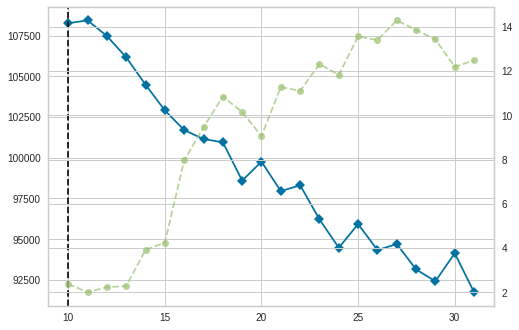

In [4]:
from sklearn.cluster import KMeans
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
from yellowbrick.cluster import KElbowVisualizer

#https://scikit-learn.org/stable/modules/clustering.html
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10,32))

visualizer.fit(vs)

n_clusters =  visualizer.elbow_value_

#visualizer.show()    
n_clusters

In [19]:
from sklearn.cluster import KMeans

kmc = KMeans(n_clusters=10, random_state=0)
kmc.fit(X=vs)

df = df.copy().dropna(subset=['Qkeys'])
df["label1"] = kmc.labels_

#vemos los primeros clusters, al ser con ngrams  la forma en la que comienza la pregunta tiene mucho peso
def print_kmc_clus(n=10):
    import random
    q_clus = [[] for i in range(n_clusters)]

    for sentence_id, cluster_id in enumerate(kmc.labels_):
        q_clus[cluster_id].append(df.iloc[sentence_id].Q)

    for i, cluster in enumerate(q_clus):
        print("Cluster ", i+1)
        for tw in random.sample(cluster, n):
            print(tw)
        print("\n")
print_kmc_clus()


Cluster  1
what's the story off your nick name?
Which saying is completely invalid nowadays?
Who’s the best female comedian?
Sleep paralysis? Anyone?
Who is the female version of Tom Hanks?
Are you happy being the person you are naturally?
Who is the best US President in your opinion?
If WW3 was started who would win?
WHO is YOUR best buddy in childhood?
Which older video games need more recognition?


Cluster  2
What movie can you recommend to beat depression?
What should be much less cheap than it is?
What’s the most disturbing scene from a movie?
What is your  I dodged a bullet  moment?
What would you do if you had super speed?
What’s 1 meme that you wish was resurrected?
 What’s your personality type?
What are the signs of maturity?
What is your favorite Taylor Swift song?
What would MLK think of BLM and antifa?


Cluster  3
Which is better? Reddit or Twitter?
Reddit, what are some free underrated apps?
Is the Oxford comma necessary? Why or why not?
Why does sparkling water taste l

### Meassuring "presition"

inertia, silhuete, own_metric


In [20]:
df["label1"] = kmc.labels_
#Compara la cantidad de aciertos con los df de test
def check_results():

    n = len(true_df)
    m = len(false_df)
    same_c = 0
    for i in range(n):
        if int(df.loc[true_df.iloc[i][0]].label1) ==  int(df.loc[true_df.iloc[i][1]].label1):
            same_c += 1
    
    diff_c = 0
    for i in range(m):
        if int(df.loc[false_df.iloc[i][0]].label1) !=  int(df.loc[false_df.iloc[i][1]].label1):
            diff_c += 1
        
    return same_c/n, diff_c/m
        
check_results()
    

(0.35882828282828283, 0.7212772127721278)

In [10]:
#continuo viendo que funciona

#embeddings preentrenados
# import gensim.downloader

# #word2vec-google-news-300
# w2v = gensim.downloader.load('glove-twitter-25')
# w2v["mauro"]

df

,Qscore,Q,Qless,Qlemmas,Qkeys,Qtags,ANSscore,ANS,Aless,Alemmas,Akeys,label1
id,,,,,,,,,,,,
bc60pk,14,"Donut or doughnut, & where are you from?","Donut doughnut, & ?","Donut doughnut , & ?",Donut_NNP doughnut_NN,NaN,6.0,"donut, southern usa","donut, southern usa","donut , southern usa",donut_NN usa_NN,3
289mmm,2,Help finding a song from a video description?,Help finding song video description?,Help finding song video description ?,Help_NNP finding_NN song_NN video_NN descripti...,NaN,2.0,/r/tipofmytongue,/r/tipofmytongue,/r/tipofmytongue,/r/tipofmytongue_NN,6
rufpr/,898,"I was rapedNo, we had sex","I rapedNo, sex","I rapedNo , sex",rapedNo_VBP sex_NN,I_PRP rapedNo_VBP,1286.0,"if its not a yes, its no.","yes, .","yes , .",yes_RB,3
24vtw3,22,Jesus H. Christ what's his middle name?,Jesus H. Christ 'middle name?,Jesus H. Christ 'middle name ?,Jesus_NNP H._NNP Christ_NNP name_NN,NaN,35.0,umm... Holy. As in Holy Christ. Isn't this com...,umm... Holy. As Holy Christ. Isn'common knowle...,umm ... Holy . As Holy Christ . Isn'common kno...,umm_NN Holy_NNP Holy_NNP Christ_NNP Isn'common...,3
sv054/,0,Judith from hotmail sent me a message..... ),Judith hotmail sent message..... ),Judith hotmail sent message ..... ),Judith_NNP hotmail_NN sent_VBD message_NN .......,sent_VBD,3.0,sounds like a great idea!,sounds like great idea!,sound like great idea !,sound_NN idea_NN,3
...,...,...,...,...,...,...,...,...,...,...,...,...
orgpc4,1,"Quiet people, what are your strengths?","Quiet people, strengths?","Quiet people , strength ?",people_NNS strength_NN,NaN,4.0,"Observing, attention, memory,","Observing, attention, memory,","Observing , attention , memory ,",Observing_NN attention_NN memory_NN,0
og7m7k,1,What is the best indian movie?,What best indian movie?,What best indian movie ?,movie_NN,What_WP,2.0,Why is this a quote?,Why quote?,Why quote ?,quote_NN,9
olnost,1,"Who's the best MC's, Biggie, Jay-Z, and Nas?","Who'best MC', Biggie, Jay-Z, Nas?","Who'best MC ' , Biggie , Jay-Z , Nas ?",Who'best_NNP MC_NNP Biggie_NNP Jay-Z_NNP Nas_NNP,NaN,1.0,whyd you put your question in quotes?,whyd put question quotes?,whyd put question quote ?,whyd_NN put_VBD question_NN quote_NN,3


In [15]:
kmc.labels_

array([3, 6, 3, ..., 3, 3, 0], dtype=int32)

## Classifying 
